In [ ]:
# %pip install pandas --quiet
# %pip install matplotlib --quiet
# %pip install seaborn --quiet
# %pip install tabulate --quiet
# %pip install pyspark --quiet

In [ ]:
#importação de pacotes

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tabulate import tabulate
# from pyspark.sql import SparkSession

In [ ]:
# spark = SparkSession.builder.appName("homicidios_pela_policia").getOrCreate()

# spark.sql("CREATE DATABASE bronze")
# spark.sql("CREATE DATABASE silver")
# spark.sql("CREATE DATABASE gold")

# schemas = spark.sql("SHOW DATABASES")
# schemas.show()

In [ ]:
# importação de tabelas

fato = pd.read_csv("alternative data\PoliceKillingsUS.csv", encoding="latin1")

dimensao_renda_mediana = pd.read_csv(
    "alternative data\MedianHouseholdIncome2015.csv", encoding="latin1"
)

dimensao_linha_pobreza = pd.read_csv(
    "alternative data\PercentagePeopleBelowPovertyLevel.csv", encoding="latin1"
)

dimensao_escolaridade = pd.read_csv(
    "alternative data\PercentOver25CompletedHighSchool.csv", encoding="latin1"
)

dimensao_percentual_racas = pd.read_csv(
    "alternative data\ShareRaceByCity.csv", encoding="latin1"
)

dimensao_populacao = pd.read_csv(
    "alternative data\sub-est2019_all.csv",
    encoding="latin1",
)

codigos_cidades = pd.read_csv(
    "alternative data/fips_codes.csv",
    encoding="latin1",
)


In [ ]:
def tipo_coluna(coluna):
    if pd.api.types.is_numeric_dtype(fato[coluna]):
        return "Numérica"
    else:
        return "Categórica"
    
def categorizar_quartis(df_input, coluna):

    df = df_input.copy()

    quartil_1 = df[coluna].quantile(0.25)
    quartil_2 = df[coluna].quantile(0.5)
    quartil_3 = df[coluna].quantile(0.75)

    bins = [
        df[coluna].min(),
        quartil_1,
        quartil_2,
        quartil_3,
        df[coluna].max(),
    ]

    labels = [
        "1º quartil",
        "2º quartil",
        "3º quartil",
        "4º quartil",
    ]

    categorias = pd.cut(
        df[coluna],
        bins=bins,
        labels=labels,
        include_lowest=True,
    )

    categorias = categorias.cat.add_categories("Não informado")

    df["Categoria"] = categorias.fillna("Não informado").astype(str)

    return df

def converter_numerico(df_input, coluna):
    df = df_input.copy()

    df[coluna] = pd.to_numeric(
        df[coluna], errors="coerce"
    )

    return df

def padronizar_cidades(df, coluna, lista_strings):
    df = df.copy()
    df[coluna] = df[coluna].replace(lista_strings, "", regex=True)
    df[coluna] = df[coluna].str.strip()
    return df



In [ ]:
info = [
    [coluna, fato[coluna].dtype, tipo_coluna(coluna), fato[coluna].isnull().sum(), fato[coluna].nunique()]
    for coluna in fato.columns
]

headers = ["Coluna", "Tipo de Dado", "Categoria", "Valores Nulos", "Valores Únicos"]
tabela = tabulate(info, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"))

print("\nAnálise da tabela fato\n")
print(tabela)

A tabela fato é constituída por uma variável de "id", uma variável numérica (idade) e 12 variáveis categóricas. Vamos agora avaliar como essas variáveis categóricas se distribuem.

In [ ]:
contagem_nomes = fato["name"].count()

print(f"Total de óbitos presentes na base:  {contagem_nomes}")

groupby_nomes = fato.groupby("name")["id"].count().reset_index(name="Quantidade").sort_values(by="Quantidade", ascending=False)

groupby_nomes = groupby_nomes[groupby_nomes["Quantidade"] > 1].rename(columns={"name": "Nome"})

groupby_nomes = tabulate(groupby_nomes, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))

print(f"\nNomes repetidos na base:\n\n{groupby_nomes}")


Conforme pode ser verificado acima, alguns dos nomes aparecem duplicidade na base. Como não há, nos dados, um identificador específico de cada pessoa (por exemplo, CPF), é possível que os óbitos de fato tenham ocorrido entre homônimos. No entanto, chama a atenção a repetição de valores de nome "TK TK" ou "TK Tk", o que parece ser algum tipo de inconsistência no registro das informações.

In [ ]:
repetidos_cidades = (
    fato[fato["name"].isin(["TK TK", "TK tk"])]
    .groupby("city")["id"]
    .count()
    .reset_index(name="Quantidade")
    .sort_values(by="Quantidade", ascending=False)
    .rename(columns={"city": "Cidade"})
)

repetidos_cidades = repetidos_cidades[repetidos_cidades["Quantidade"] > 1]

repetidos_cidades = tabulate(repetidos_cidades, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))

print(f"\nCidades associadas a nomes aparentemente inconsistentes:\n\n{repetidos_cidades}")

In [ ]:
colunas = ["manner_of_death", "gender", "race", "signs_of_mental_illness", "threat_level", "flee", "body_camera"]

for coluna in colunas:
    groupby = fato.groupby(coluna)["id"].count().reset_index(name="Quantidade").sort_values(by="Quantidade", ascending=False)
    groupby = tabulate(groupby, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))
    print(f"\nValores Únicos da coluna '{coluna}':\n\n{groupby}")

In [ ]:
#substituindo categorias

print(f"Menor data observada na base: {fato['date'].min()}")

print(f"Maior data observada na base: {fato['date'].max()}")

silver_fato = fato.copy()

silver_fato["mes"] = pd.to_datetime(silver_fato['date'], format="%d/%m/%y").dt.month
silver_fato["ano"] = pd.to_datetime(silver_fato['date'], format="%d/%m/%y").dt.year

def categorizar(valor):
    if valor == "unarmed":
        return "Desarmado"
    elif "unknown" in str(valor) or valor == "undetermined":
        return "Desconhecido"
    else:
        return "Armado"
    
silver_fato["categoria_armado"] = silver_fato["armed"].apply(categorizar)

silver_fato = padronizar_cidades(silver_fato, "city", ["city", "CDP", "town"])


In [ ]:
silver_fato = silver_fato.dropna(subset=["race"])

silver_fato["raca"] = (
    silver_fato["race"]
    .map(
        {
            "A": "Asiático",
            "W": "Branco",
            "H": "Hispânico",
            "B": "Preto",
            "O": "Outros",
            "N": "Indígena",
        }
    )
)

silver_fato["cidade"] = silver_fato["city"] + ", " + silver_fato["state"]

silver_fato["camera_corporal"] = silver_fato["body_camera"].map(
    {True: "Sim", False: "Não"}
)

silver_fato["nivel_ameaca"] = silver_fato["threat_level"].map(
    {"attack": "Ataque", "undetermined": "Indeterminado", "other": "Outros"}
)

silver_fato["genero"] = silver_fato["gender"].map({"M": "Masculino", "F": "Feminino"})

silver_fato = silver_fato.drop(
    columns={
        "name",
        "date",
        "manner_of_death",
        "age",
        "armed",
        "gender",
        "race",
        "city",
        "state",
        "signs_of_mental_illness",
        "threat_level",
        "flee",
        "body_camera",
    }
)

### 1ª Tabela Dimensão - Renda Mediana das Cidades Americanas

In [ ]:
silver_dimensao_renda_mediana = dimensao_renda_mediana.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_renda_mediana.columns,
    "Tipo": silver_dimensao_renda_mediana.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_renda_mediana.isnull().sum(),
    "Valores Únicos": silver_dimensao_renda_mediana.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Renda Mediana das Cidades Americanas':\n\n{tabela}")


In [ ]:
#renomear colunas para facilitar a referência

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.rename(
    columns={"Median Income": "renda_mediana"}
)

#padronização do nome das cidades

silver_dimensao_renda_mediana = padronizar_cidades(
    silver_dimensao_renda_mediana, "City", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_renda_mediana = converter_numerico(
    silver_dimensao_renda_mediana, "renda_mediana"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_renda_mediana["cidade"] = (
    silver_dimensao_renda_mediana["City"]
    + ", "
    + silver_dimensao_renda_mediana["Geographic Area"]
)

#substituir valores não preenchidos pela média dos respectivos estados

silver_dimensao_renda_mediana["renda_mediana"] = silver_dimensao_renda_mediana[
    "renda_mediana"
].fillna(
    silver_dimensao_renda_mediana.groupby("Geographic Area")["renda_mediana"].transform(
        "mean"
    )
)

#verificar se há registros duplicados

silver_dimensao_renda_mediana[silver_dimensao_renda_mediana["cidade"].duplicated()]

In [ ]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.groupby(["cidade"], dropna=False)["renda_mediana"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_renda_mediana = categorizar_quartis(silver_dimensao_renda_mediana, "renda_mediana")

#tabela final

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.rename(columns={"Categoria": "quartil_renda_mediana"})

In [ ]:
#verificar graficamente a distribuição de renda mediana

grafico = sns.histplot(
    silver_dimensao_renda_mediana["renda_mediana"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nRenda Mediana", ylabel="Frequência\n", title="Distribuição da Renda Mediana das Cidades Americanas\n"
)

plt.gcf().set_facecolor("whitesmoke")

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()


### 2ª Tabela Dimensão - Percentual da população abaixo da linha da pobreza das cidades americanas

In [ ]:
silver_dimensao_linha_pobreza = dimensao_linha_pobreza.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_linha_pobreza.columns,
    "Tipo": silver_dimensao_linha_pobreza.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_linha_pobreza.isnull().sum(),
    "Valores Únicos": silver_dimensao_linha_pobreza.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Percentual da População Abaixo da Linha da Pobreza':\n\n{tabela}")

In [ ]:
#renomear colunas para facilitar a referência

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.rename(
    columns={"poverty_rate": "indice_pobreza"}
)

#padronização do nome das cidades

silver_dimensao_linha_pobreza = padronizar_cidades(
    silver_dimensao_linha_pobreza, "City", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_linha_pobreza = converter_numerico(
    silver_dimensao_linha_pobreza, "indice_pobreza"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_linha_pobreza["cidade"] = (
    silver_dimensao_linha_pobreza["City"]
    + ", "
    + silver_dimensao_linha_pobreza["Geographic Area"]
)

#verificar se há registros duplicados

silver_dimensao_linha_pobreza[silver_dimensao_linha_pobreza["cidade"].duplicated()]

In [ ]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.groupby(["cidade"], dropna=False)["indice_pobreza"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_linha_pobreza = categorizar_quartis(silver_dimensao_linha_pobreza, "indice_pobreza")

#tabela final

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.rename(columns={"Categoria": "quartil_linha_pobreza"})

In [ ]:
#verificar graficamente a distribuição da população abaixo da linha da pobreza

grafico = sns.histplot(
    silver_dimensao_linha_pobreza["indice_pobreza"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nPercentual", ylabel="Frequência\n", title="Distribuição da População Abaixo da Linha da Pobreza por Cidade\n"
)

plt.gcf().set_facecolor("whitesmoke")

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()


### 3ª Tabela Dimensão - Percentual da população que completou o Ensino Médio

In [ ]:
silver_dimensao_escolaridade = dimensao_escolaridade.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_escolaridade.columns,
    "Tipo": silver_dimensao_escolaridade.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_escolaridade.isnull().sum(),
    "Valores Únicos": silver_dimensao_escolaridade.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'População que Completou o Ensino Médio':\n\n{tabela}")

In [ ]:
#renomear colunas para facilitar a referência

silver_dimensao_escolaridade = silver_dimensao_escolaridade.rename(
    columns={"percent_completed_hs": "percentual_em"}
)

#padronização do nome das cidades

silver_dimensao_escolaridade = padronizar_cidades(
    silver_dimensao_escolaridade, "City", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_escolaridade = converter_numerico(
    silver_dimensao_escolaridade, "percentual_em"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_escolaridade["cidade"] = (
    silver_dimensao_escolaridade["City"]
    + ", "
    + silver_dimensao_escolaridade["Geographic Area"]
)

#verificar se há registros duplicados

silver_dimensao_escolaridade[silver_dimensao_escolaridade["cidade"].duplicated()]

In [ ]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_escolaridade = silver_dimensao_escolaridade.groupby(["cidade"], dropna=False)["percentual_em"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_escolaridade = categorizar_quartis(silver_dimensao_escolaridade, "percentual_em")

#tabela final

silver_dimensao_escolaridade = silver_dimensao_escolaridade.rename(columns={"Categoria": "quartil_percentual_em"})

In [ ]:
#verificar graficamente a distribuição da população que completou o Ensino Médio

grafico = sns.histplot(
    silver_dimensao_escolaridade["percentual_em"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nPercentual", ylabel="Frequência\n", title="Distribuição da População que Completou o Ensino Médio\n"
)

plt.gcf().set_facecolor("whitesmoke")

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()


### 4ª Tabela Dimensão - Distribuição de Raças das Cidades Americanas

In [ ]:
silver_dimensao_percentual_racas = dimensao_percentual_racas.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_percentual_racas.columns,
    "Tipo": silver_dimensao_percentual_racas.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_percentual_racas.isnull().sum(),
    "Valores Únicos": silver_dimensao_percentual_racas.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Distribuição de Raças das Cidades Americanas':\n\n{tabela}")

In [ ]:
# renomear colunas para facilitar a referência

silver_dimensao_percentual_racas = silver_dimensao_percentual_racas.rename(
    columns={
        "share_white": "percentual_brancos",
        "share_black": "percentual_pretos",
        "share_native_american": "percentual_indigenas",
        "share_asian": "percentual_asiaticos",
        "share_hispanic": "percentual_hispanicos",
    }
)

# padronização do nome das cidades

silver_dimensao_percentual_racas = padronizar_cidades(silver_dimensao_percentual_racas, "City", ["city", "CDP", "town"])

# converter a coluna de interesse para o formato numérico

colunas = silver_dimensao_percentual_racas.columns.drop(["Geographic area", "City"])

for coluna in colunas:
    silver_dimensao_percentual_racas = converter_numerico(
        silver_dimensao_percentual_racas, coluna
    )

# concatenação dos nomes de cidades e estados

silver_dimensao_percentual_racas["cidade"] = (
    silver_dimensao_percentual_racas["City"]
    + ", "
    + silver_dimensao_percentual_racas["Geographic area"]
)

# verificar se há registros duplicados

silver_dimensao_percentual_racas[silver_dimensao_percentual_racas["cidade"].duplicated()]

In [ ]:
#agrupar resultados duplicados pela média entre eles

silver_dimensao_percentual_racas = silver_dimensao_percentual_racas.groupby(["cidade"], dropna=False)[colunas].mean(numeric_only=True).reset_index()

#verificar graficamente a distribuição da população por raças

num_rows = (len(colunas) // 2) + (len(colunas) % 2)
figura, eixos = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 3))
eixos = eixos.flatten()

for i, coluna in enumerate(colunas):
    sns.histplot(silver_dimensao_percentual_racas[coluna], bins=40, ax=eixos[i], color="#ffb2f9", edgecolor="#FFFFFF")
    eixos[i].set_title(f"Distribuição de {coluna}\n")
    eixos[i].set_xlabel("\nPercentual")
    eixos[i].set_ylabel("Frequência\n")
    eixos[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    eixos[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

for j in range(i + 1, len(eixos)):
    eixos[j].set_visible(False)

figura.set_facecolor("whitesmoke")
plt.tight_layout()
plt.show()


### 5ª Tabela Dimensão - População por Cidade

In [ ]:
silver_codigos_cidades = codigos_cidades.copy()

silver_codigos_cidades = silver_codigos_cidades.rename(
    columns={"STATE": "estado", "STATEFP": "codigo_estado"}
)

silver_codigos_cidades = silver_codigos_cidades[
    ["estado", "codigo_estado"]
].drop_duplicates(subset=["estado", "codigo_estado"])

silver_dimensao_populacao = dimensao_populacao.copy()

silver_dimensao_populacao = silver_dimensao_populacao.merge(
    silver_codigos_cidades, left_on="STATE", right_on="codigo_estado", validate="m:1"
)

silver_dimensao_populacao = silver_dimensao_populacao[
    ["estado", "NAME", "POPESTIMATE2016"]
]

silver_dimensao_populacao = padronizar_cidades(
    silver_dimensao_populacao, "NAME", ["city", "CDP", "town"]
)

silver_dimensao_populacao["cidade"] = silver_dimensao_populacao["NAME"] + ", " + silver_dimensao_populacao["estado"]

silver_dimensao_populacao = silver_dimensao_populacao.drop_duplicates()

silver_dimensao_populacao = silver_dimensao_populacao.groupby(["cidade"], dropna=False)["POPESTIMATE2016"].mean(numeric_only=True).reset_index()

silver_dimensao_populacao = silver_dimensao_populacao.rename(columns={"POPESTIMATE2016": "estimativa_populacao"})

In [ ]:
gold = (
    silver_fato.merge(
        silver_dimensao_renda_mediana,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_escolaridade,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_linha_pobreza,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_percentual_racas,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_populacao, 
        on=["cidade"], 
        validate="m:1", 
        how="left")
)

gold = gold.dropna()

In [ ]:
gold

In [ ]:
groupby = gold.groupby("quartil_renda_mediana")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_renda_mediana")

grafico = sns.barplot(
    data=groupby,
    x="quartil_renda_mediana",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nRenda Mediana por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - Renda Mediana\n")

plt.show()

In [ ]:
groupby = gold.groupby("quartil_linha_pobreza")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_linha_pobreza")

grafico = sns.barplot(
    data=groupby,
    x="quartil_linha_pobreza",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nPopulação Abaixo da Linha da Pobreza por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - População Abaixo da Linha da Pobreza\n")

plt.show()

In [ ]:
groupby = gold.groupby("quartil_percentual_em")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_percentual_em")

grafico = sns.barplot(
    data=groupby,
    x="quartil_percentual_em",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nEnsino Médio Completo por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - População com Ensino Médio Completo\n")

plt.show()

In [ ]:
groupby = gold.groupby("quartil_percentual_em")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_percentual_em")

grafico = sns.barplot(
    data=groupby,
    x="quartil_percentual_em",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nEnsino Médio Completo por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - População com Ensino Médio Completo\n")

plt.show()

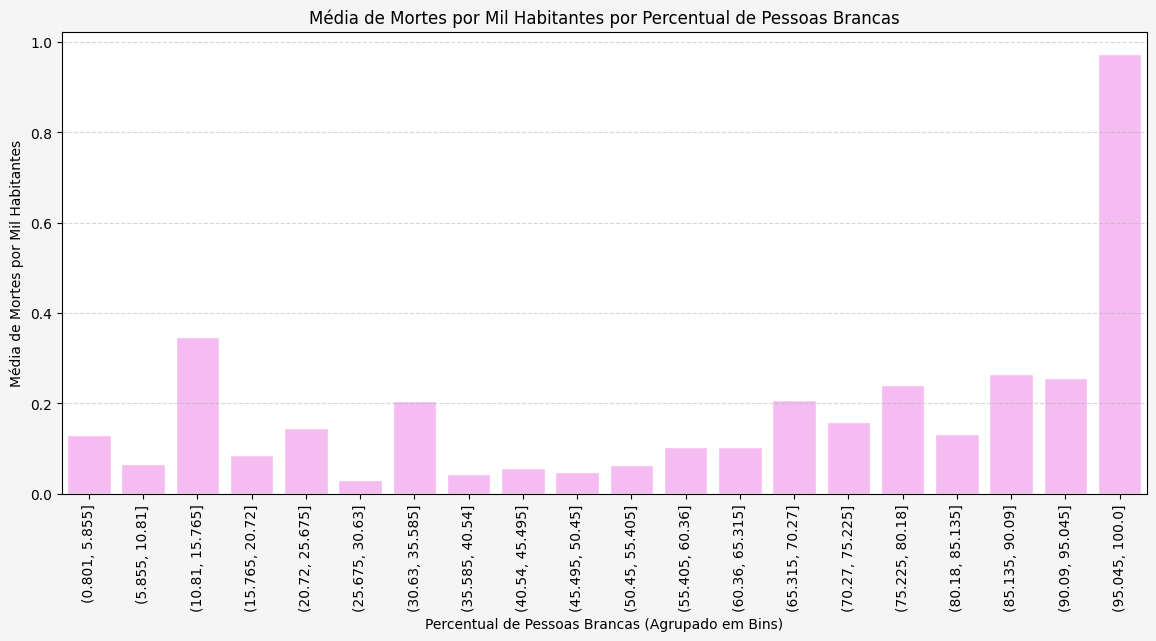

In [ ]:
gold2 = (
    gold.groupby("cidade")["id"]
    .count()
    .reset_index(name="quantidade")
    .sort_values(by="quantidade", ascending=False)
    .merge(
        gold[
            [
                "cidade",
                "estimativa_populacao",
                "percentual_brancos",
                "percentual_pretos",
                "percentual_hispanicos",
                "percentual_asiaticos",
                "percentual_indigenas"
            ]
        ].drop_duplicates(),
        validate="m:1",
        how="left",
        on="cidade",
    )
)

gold2["mortes_mil_habitantes"] = (
    gold2["quantidade"] / gold2["estimativa_populacao"] * 1000
)


gold2["bins"] = pd.cut(gold2["percentual_brancos"], bins=20)

gold_grouped = gold2.groupby("bins", observed=False)["mortes_mil_habitantes"].mean().reset_index()

gold_grouped["bins"] = gold_grouped["bins"].astype(str)

plt.figure(figsize=(14, 6))
sns.barplot(
    x=gold_grouped["bins"],
    y=gold_grouped["mortes_mil_habitantes"],
    color="#ffb2f9",
    edgecolor="#FFFFFF",
)

plt.xticks(rotation=90)
plt.xlabel("Percentual de Pessoas Brancas (Agrupado em Bins)")
plt.ylabel("Média de Mortes por Mil Habitantes")
plt.title("Média de Mortes por Mil Habitantes por Percentual de Pessoas Brancas")

# Ajustar fundo e exibir o gráfico
plt.gcf().set_facecolor("whitesmoke")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


<Axes: xlabel='percentual_brancos', ylabel='Count'>

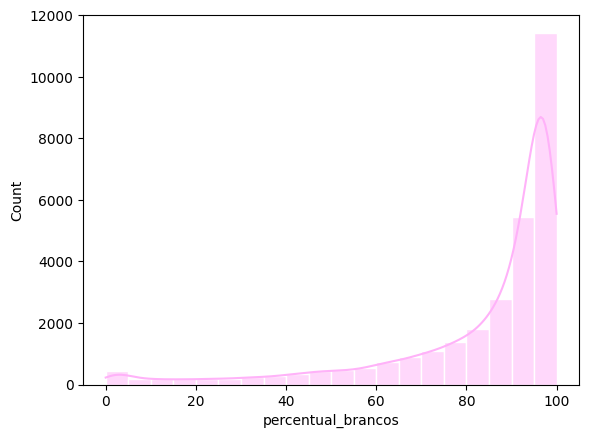

In [61]:
sns.histplot(
    silver_dimensao_percentual_racas["percentual_brancos"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

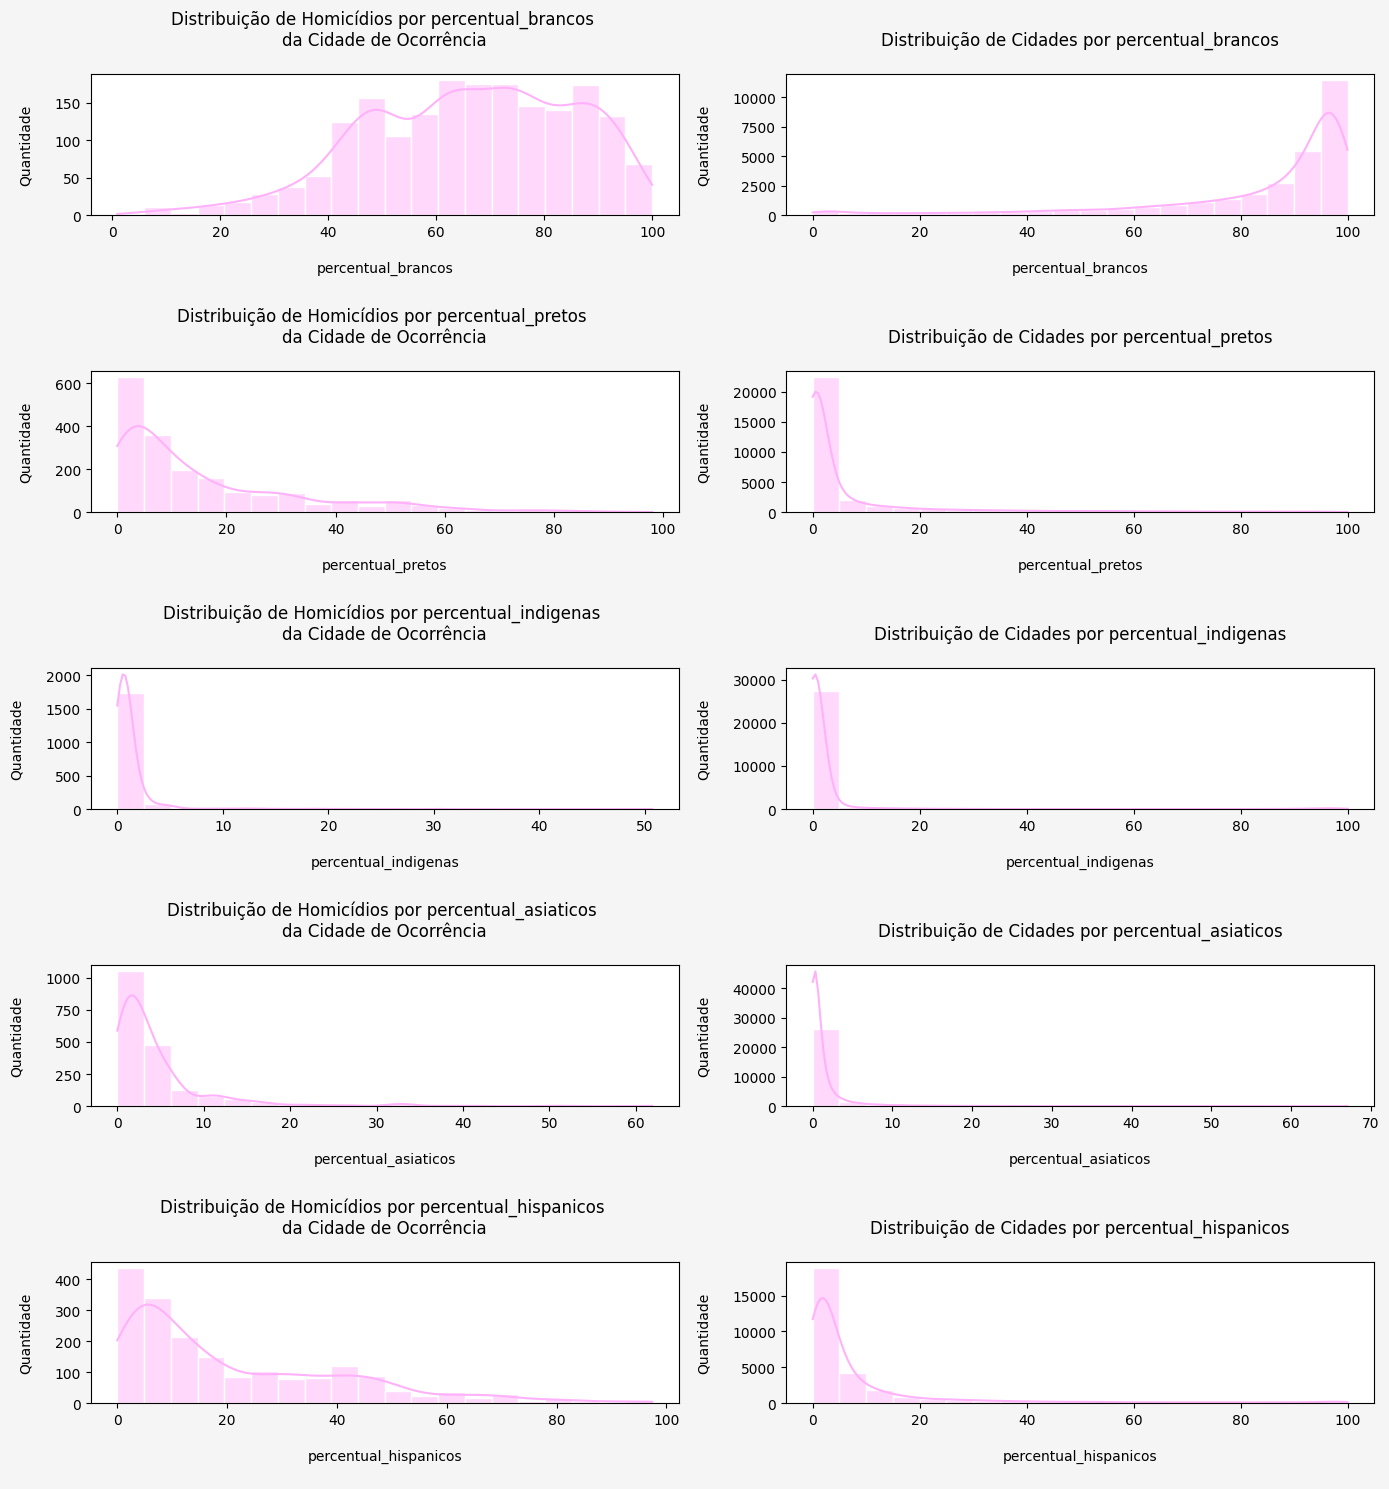

In [44]:
groupby = gold.groupby("percentual_pretos")["id"].count().reset_index(name="Quantidade").sort_values(by="percentual_pretos")

#agrupar resultados duplicados pela média entre eles

silver_dimensao_percentual_racas = silver_dimensao_percentual_racas.groupby(["cidade"], dropna=False)[colunas].mean(numeric_only=True).reset_index()

num_rows = len(colunas)
figura, eixos = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 3))
eixos = eixos.flatten()

for i, coluna in enumerate(colunas):
    sns.histplot(
        gold[coluna],
        bins=20,
        color="#ffb2f9",
        edgecolor="#FFFFFF",
        kde=True,
        ax=eixos[i * 2]
    )
    eixos[i * 2].set_xlabel(f"\n{coluna}\n")
    eixos[i * 2].set_ylabel("Quantidade\n")
    eixos[i * 2].set_title(f"Distribuição de Homicídios por {coluna} \nda Cidade de Ocorrência\n")

    sns.histplot(
        silver_dimensao_percentual_racas[coluna],
        bins=20,
        color="#ffb2f9",
        edgecolor="#FFFFFF",
        kde=True,
        ax=eixos[i * 2 + 1]  # Organizando corretamente a estrutura em pares
    )
    eixos[i * 2 + 1].set_xlabel(f"\n{coluna}\n")
    eixos[i * 2 + 1].set_ylabel("Quantidade\n")
    eixos[i * 2 + 1].set_title(f"Distribuição de Cidades por {coluna}\n")

# Ajustar fundo da imagem uma única vez
figura.set_facecolor("whitesmoke")

# Melhorar layout e remover possíveis eixos vazios
plt.tight_layout()
plt.show()